In [29]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [30]:
from google.colab import drive
drive.mount ('/content/drive')

from IPython.display import Image


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


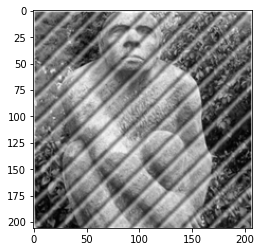

In [59]:
# img = cv2.imread('/content/drive/MyDrive/IMP301/PT2/data/cameraman_noise.png', 0)
# plt.imshow(img, cmap='gray')
# plt.show()
# img1 = cv2.imread('/content/drive/MyDrive/IMP301/PT2/data/printsalesgallery-thephotographers-gallery-wolfgang-suschitzky-guy-the-gorilla-london-zoo-1958.jpg', 0)
# plt.imshow(img1, cmap='gray')
# plt.show()
img = cv2.imread('/content/drive/MyDrive/IMP301/PT2/data/1Untitled.png', 0)
plt.imshow(img, cmap='gray')
plt.show()

In [32]:
# Defining M,N as number of rows and columns respectively
M, N = img.shape

# Get the fourier transform of the image
F = np.fft.fft2(img)

#Shift zero to center
F = np.fft.fftshift(F)

In [33]:
# ideal band reject filter
def IBF(F, C0, W):
    M,N = F.shape
    H = np.zeros((M, N), dtype=np.complex128)
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            if D <= C0 - W/2 or D >= C0 + W/2:
                H[u,v] = 1
            else:
                H[u,v] = 0
    return H
    


In [34]:
# butterworth band reject filter
def BBF(F, C0, W, n):
    M,N = F.shape
    H = np.zeros((M, N), dtype=np.complex128)
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            H[u,v] = 1/(1 + ((D*W)/(D**2 - C0**2))**(2*n))
    return H

In [35]:
# gaussian band reject filter
def GBF(F, C0, W):
    M,N = F.shape
    H = np.zeros((M, N), dtype=np.complex128)
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            H[u,v] = 1 - np.exp(-1/2*((D**2 - C0**2)/(D*W))**2)
    return H

In [36]:
# Defining the parameters
C0 = 35/2
W = 8 #8
n = 1 # For butterworth filter only

# Apply the filters
H_IBF = IBF(F, C0, W)
H_BBF = BBF(F, C0, W, n)
H_GBF = GBF(F, C0, W)

<ipython-input-34-d06715bcde54>:8: RuntimeWarning: divide by zero encountered in double_scalars
  H[u,v] = 1/(1 + ((D*W)/(D**2 - C0**2))**(2*n))


In [37]:
# Transforming
G_IBF = H_IBF*F
G_BBF = H_BBF*F
G_GBF = H_GBF*F
# Spectrum
ori  = 20*np.log(np.abs(F))
S_IBF = 20*np.log(np.abs(G_IBF))
S_BBF = 20*np.log(np.abs(G_BBF))
S_GBF = 20*np.log(np.abs(G_GBF))
# Unshift 
I_IBF = np.fft.ifftshift(G_IBF)
I_BBF = np.fft.ifftshift(G_BBF)
I_GBF = np.fft.ifftshift(G_GBF)

# Inverse Fourier Transform
g_IBF = np.fft.ifft2(I_IBF)
g_BBF = np.fft.ifft2(I_BBF)
g_GBF = np.fft.ifft2(I_GBF)

<ipython-input-37-39e510298d69>:7: RuntimeWarning: divide by zero encountered in log
  S_IBF = 20*np.log(np.abs(G_IBF))
<ipython-input-37-39e510298d69>:8: RuntimeWarning: divide by zero encountered in log
  S_BBF = 20*np.log(np.abs(G_BBF))
<ipython-input-37-39e510298d69>:9: RuntimeWarning: divide by zero encountered in log
  S_GBF = 20*np.log(np.abs(G_GBF))


In [38]:
ori = np.uint32(np.abs(ori))
S_IBF = np.uint32(np.abs(S_IBF))
S_BBF = np.uint32(np.abs(S_BBF))
S_GBF = np.uint32(np.abs(S_GBF))

I_IBF = np.uint32(np.abs(g_IBF))
I_BBF = np.uint32(np.abs(g_BBF))
I_GBF = np.uint32(np.abs(g_GBF))

In [39]:
img_arr = [img, I_IBF, I_BBF, I_GBF, ori, S_IBF, S_BBF, S_GBF]
name_arr = ['Original', 'IBF', 'BBF', 'GBF','Spectrum_ori', 'Spectrum_IBF', 'Spectrum_BBF', 'Spectrum_GBF']

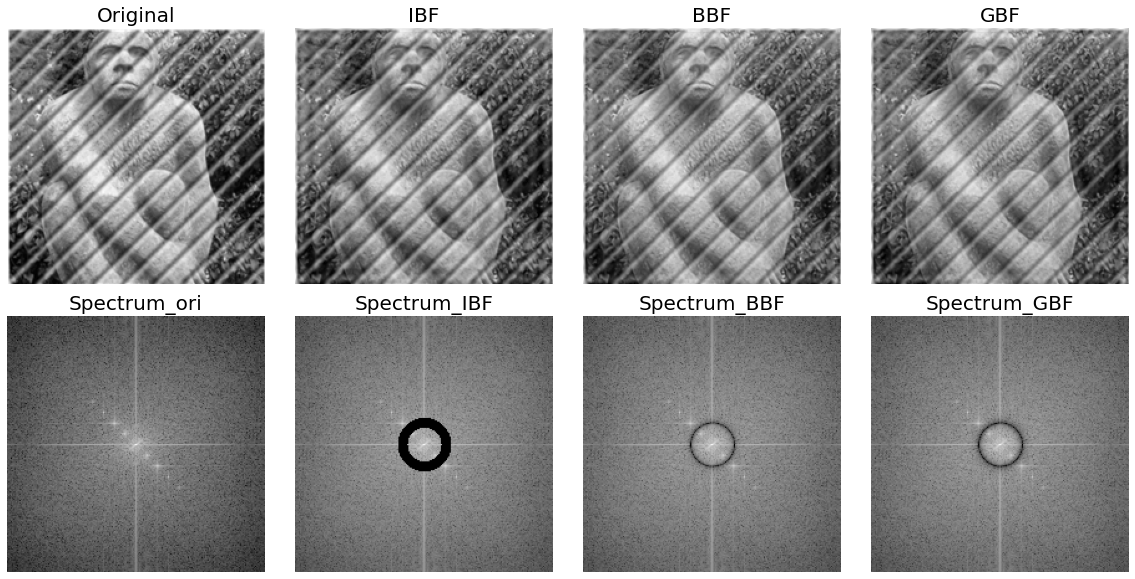

In [40]:
cols,rows = 4,2
fig,axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*4,rows*4))
#tight fig
fig.tight_layout(pad=0)
#black background
# fig.patch.set_facecolor('black')
i = 0
j = 0
x = 0
while( x < 8):
  if j == 1:
    for i in range(0,4):
      axes[j][i].set_title(name_arr[x],fontsize=20,color='black')
      axes[j][i].imshow(img_arr[x],cmap='gray')
      axes[j][i].axis('off')
      x+=1
    break
  elif j == 0 :
      for i in range(0,4):
        axes[j][i].set_title(name_arr[x],fontsize=20,color='black')
        axes[j][i].imshow(img_arr[x],cmap='gray')
        axes[j][i].axis('off')
        x += 1
      j +=1

plt.show()

In [42]:
import math
import cv2 as cv
import numpy as np
from skimage.util import random_noise


def bgFilterTF4e(type, M, N, C0, W):
    """
    Filter in the frequency domain
    @param:
    1. type: can be gaussian or ideal
    2. M = row
    3. N = col
    4. W = the W value
    @return
    The mask of the Gaussian or ideal
    """
    if type == "Gaussian":
        d0 = C0
        # rows, cols = shape
        rows = M
        cols = N

        mask = np.zeros((rows, cols))
        mid_row, mid_col = int(rows / 2), int(cols / 2)
        for i in range(rows):
            for j in range(cols):
                d = math.sqrt((i - mid_row) ** 2 + (j - mid_col) ** 2)
                if d == 0:
                    mask[i, j] = np.exp(-(((d * d - d0 * d0) / 0.000001 * W) ** 2))
                else:
                    mask[i, j] = np.exp(-(((d * d - d0 * d0) / d * W) ** 2))
        return mask

    elif type == "Ideal":
        d0 = C0
        rows = M
        cols = N

        mask = np.zeros((rows, cols))
        mid_row, mid_col = int(rows / 2), int(cols / 2)
        for i in range(rows):
            for j in range(cols):
                d = math.sqrt((i - mid_row) ** 2 + (j - mid_col) ** 2)
                lower_range = d0 - W / 2
                upper_rangge = d0 + W / 2
                if d >= lower_range and d <= upper_rangge:
                    mask[i, j] = 1
                else:
                    mask[i, j] = 0
        return mask


def post_process_image(image):
    """Post process the image to create a full constrast stretch of the image
    @param:
    The image after inverse fourier transform
    @return:
    The image with full contrast stretch
    """
    a = 0
    b = 255
    c = np.min(image)
    d = np.max(image)
    rows, cols = np.shape(image)
    out_im = np.zeros((rows, cols), dtype=int)
    for i in range(rows):
        for j in range(cols):
            if d - c == 0:  # avoid to have d-c = 0 which give infinite answer
                out_im[i, j] = ((b - a) / 0.000001) * (image[i, j] - c) + a
            else:
                out_im[i, j] = ((b - a) / (d - c)) * (image[i, j] - c) + a

    return np.uint8(out_im)




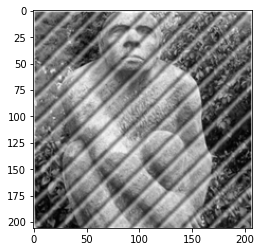

In [52]:
im = cv.imread("/content/drive/MyDrive/IMP301/PT2/data/1Untitled.png", 0)
# # 1. Input the image and obtain the padding size
# im = cv.copyMakeBorder(
# im, 512, 512, 512, 512, cv.BORDER_CONSTANT, value=0
# )  # make sure to pad
# cv.imshow("Original", im[512:1535, 512:1535])
plt.imshow(im, cmap='gray')
plt.show()

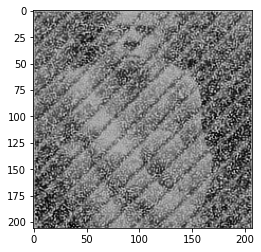

In [58]:


    # # 2. Generate the Gaussian noise
    # gauss = np.random.normal(0, 1, im.size)
    # gauss = gauss.reshape(im.shape[0], im.shape[1]).astype("uint8")

#     # Add the Gaussian noise to the image
#     im = cv.add(im, gauss)
#     plt.imshow(im, cmap='gray')
# plt.show()
   # cv.imshow("Noise-corrupted Image", im[512:1535, 512:1535])

    # 3. Get the rows and cols of the image
    M, N = np.shape(im)

    # 4. Compute the fft of the image
    fft = np.fft.fft2(im)

    # 5. Shift the fft to the center of the low frequencies
    shift_fft = np.fft.fftshift(fft)

    # 6. Get the mask
    mask = bgFilterTF4e(type="Ideal", M=M, N=N, C0=45, W=100)

    # 7. Filter the image frequency based on the mask
    filtered_image = np.multiply(mask, shift_fft)
    mag_filtered_dft = np.log(np.abs(filtered_image) + 1)
    filtered_dft = post_process_image(mag_filtered_dft)

    # 8. Compute the inverse shift
    shift_ifft = np.fft.ifftshift(filtered_image)

    # 9. Computer the inverse fourier transform
    ifft = np.fft.ifft2(shift_ifft)

    # 10. Compute the magnitude
    mag = np.abs(ifft)

    # 11. full contrast stretch
    filtered_image = post_process_image(mag)

   # cv.imshow("Ideal LPF Filtered Image", filtered_image[512:1535, 512:1535])
    plt.imshow( filtered_image, cmap='gray')
    plt.show()
    cv.waitKey(0)
    cv.destroyAllWindows()  # Allow to press enter to delete all

